In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Device dignostics code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Importing dataset

In [3]:
df = pd.read_csv(r"E:\Pytorch Datasets\Classification\wine+quality\winequality-white.csv", delimiter=';')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Filtering Data

In [5]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

In [6]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

Converting numpy to tensor

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [9]:
X.shape, y.shape

(torch.Size([4898, 11]), torch.Size([4898]))

Spliting training and testing data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3918, 11]),
 torch.Size([980, 11]),
 torch.Size([3918]),
 torch.Size([980]))

In [12]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

Build a Linear model by inheriting nn.Module

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=11, out_features=128)
        self.layer2 = nn.Linear(in_features=128, out_features=256)
        self.layer3 = nn.Linear(in_features=256, out_features=512)
        self.layer4 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    
model = Model().to(device)

In [14]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.2319, -0.1943, -0.0149,  ..., -0.1029,  0.0196, -0.2279],
                      [-0.0317,  0.1683, -0.1722,  ...,  0.0015, -0.1720, -0.2500],
                      [-0.1589,  0.2182, -0.0194,  ..., -0.1231,  0.1058, -0.1237],
                      ...,
                      [-0.0744,  0.1220,  0.1641,  ..., -0.0699, -0.1357,  0.0897],
                      [ 0.1077, -0.0468,  0.1491,  ..., -0.0498, -0.0599,  0.0766],
                      [ 0.2349, -0.1220, -0.1470,  ..., -0.2167,  0.1084,  0.2602]])),
             ('layer1.bias',
              tensor([-3.0323e-02,  2.3695e-01,  2.9633e-01, -5.1952e-02,  3.6070e-02,
                      -2.2347e-01,  1.6354e-01,  2.4711e-01,  2.7964e-01, -2.8024e-01,
                      -2.0365e-01, -2.1766e-01, -2.1862e-01, -1.8477e-01, -1.6141e-04,
                       1.7406e-01, -6.8942e-02, -1.7870e-01, -2.1153e-01,  1.6013e-01,
                       2.5461e-01, -5.0715e-02,  1.1666e-0

Testing everything is fine using dummy values

In [15]:
model.eval()

with torch.inference_mode():
    y_logits = model(X_test)

In [16]:
y_logits.shape

torch.Size([980, 10])

In [17]:
y_pred = torch.argmax(y_logits, dim=1)

Choosing Loss and Optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters()
)

Writing Training and Test loops

In [19]:
y_train = y_train.long()
y_test = y_test.long()

In [20]:
trainLoss, testLoss = [], []
trainAccuracy, testAccuracy = [], []

In [21]:
epochs = 751

for i in range(1, epochs):
    #training
    model.train()

    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)

    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_score(y_train, y_pred)

    trainLoss.append(train_loss)
    trainAccuracy.append(train_acc)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    #testing 
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)

        test_loss = loss_fn( test_logits, y_test)
        test_acc = accuracy_score(y_test, test_pred)

        testLoss.append(test_loss)
        testAccuracy.append(test_acc)

    if i % 10 == 0:
        print(f"Epoch: {i} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.4f}")

Epoch: 10 | Train Loss: 4.95140 | Train Accuracy: 0.4556 | Test Loss: 6.44115 | Test Accuracy: 0.3102
Epoch: 20 | Train Loss: 5.48863 | Train Accuracy: 0.4558 | Test Loss: 5.23269 | Test Accuracy: 0.4214
Epoch: 30 | Train Loss: 2.12466 | Train Accuracy: 0.4033 | Test Loss: 2.31976 | Test Accuracy: 0.4082
Epoch: 40 | Train Loss: 1.52965 | Train Accuracy: 0.4553 | Test Loss: 1.51719 | Test Accuracy: 0.4612
Epoch: 50 | Train Loss: 1.38019 | Train Accuracy: 0.3762 | Test Loss: 1.27640 | Test Accuracy: 0.4500
Epoch: 60 | Train Loss: 1.30052 | Train Accuracy: 0.4566 | Test Loss: 1.28417 | Test Accuracy: 0.4622
Epoch: 70 | Train Loss: 1.24807 | Train Accuracy: 0.4607 | Test Loss: 1.24592 | Test Accuracy: 0.4571
Epoch: 80 | Train Loss: 1.23284 | Train Accuracy: 0.4620 | Test Loss: 1.22979 | Test Accuracy: 0.4633
Epoch: 90 | Train Loss: 1.22761 | Train Accuracy: 0.4602 | Test Loss: 1.22621 | Test Accuracy: 0.4551
Epoch: 100 | Train Loss: 1.22455 | Train Accuracy: 0.4617 | Test Loss: 1.22526 | T

KeyboardInterrupt: 

In [ ]:
trainLoss = torch.tensor(trainLoss)
testLoss = torch.tensor(testLoss)
trainAccuracy = torch.tensor(trainAccuracy)
testAccuracy = torch.tensor(testAccuracy)

trainLoss = trainLoss.detach().numpy()
testLoss = testLoss.detach().numpy()
trainAccuracy = trainAccuracy.detach().numpy()
testAccuracy = testAccuracy.detach().numpy()

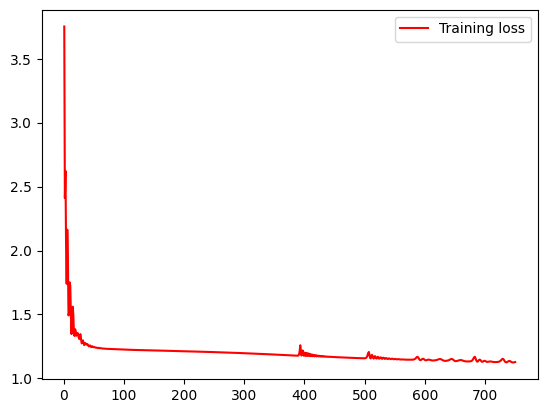

In [ ]:
plt.plot(range(1, epochs), trainLoss, 'r-', label="Training loss")
# plt.plot(range(1, epochs), testLoss, 'b-', label="Testing loss")
plt.legend()
plt.show()